# 2019-nCov Analysis, $R_0$ estimation
### Affan Shoukat

Model Fitting, stochastic simulations. The results are used to drive the R package `EpiEstim` to estimate basic reproduction numbers. 

### Reading data, plotting

In [447]:
# load packages
using Distributions, DataFrames, CSV, Query, VegaLite, LsqFit, Plots, PrettyTables, StatsPlots, Interpolations
using Base.Iterators, Random
pyplot()
#PyPlot.svg(true)

Plots.PyPlotBackend()

In [448]:
## read the data and calculate incidence.

df = CSV.read("../data/ncovdata.csv", datarow=2, header=["time", "date", "cumcases", "cumcases_intl"], types=[Int64, Int64, Union{Int64, Missing}, Int64])
dfm = stack(df, [:cumcases, :cumcases_intl], [:time], variable_name=:variable, value_name=:value);
println("data has $(nrow(dfm)) rows and $(ncol(dfm)) columns")

# are we underreporting if 20% underreporting, use factor 1.25 (1/(1-0.20)). 
# if 50% underreporting, use factor 2
# if 80% underreporting, use factor 5
ur_factor = 1
scenstr = "baseline"
datefilter = 70
df[!, :cumcases] .= Int.(round.(df.cumcases .* ur_factor))

pretty_table(df)

# we are going to redistributed the cumulative number of cases on december 16 (which is confirmed) to january 1st to 16th
#df[1:5, :cumcases] .= 0 


## calculate incidence
_tmp = circshift(df.cumcases, 1)
_tmp[1] = 0
df[!, :inc] = df.cumcases - _tmp

df = df |> @filter(_.date <= datefilter) |> DataFrame

pretty_table(df)

data has 32 rows and 3 columns
┌───────┬───────┬──────────┬───────────────────────┐
│  time │  date │ cumcases │         cumcases_intl │
│ Int64 │ Int64 │    Int64 │ Union{Missing, Int64} │
├───────┼───────┼──────────┼───────────────────────┤
│     1 │    11 │       41 │                    41 │
│     2 │    12 │       41 │               missing │
│     3 │    13 │       41 │               missing │
│     4 │    14 │       41 │               missing │
│     5 │    15 │       41 │               missing │
│     6 │    16 │       45 │                    48 │
│     7 │    17 │       62 │                    66 │
│     8 │    18 │      121 │                   125 │
│     9 │    19 │      198 │                   202 │
│    10 │    20 │      258 │                   263 │
│    11 │    21 │      363 │                   369 │
│    12 │    22 │      425 │                   434 │
│    13 │    23 │      495 │               missing │
│    14 │    24 │      572 │               missing │
│    15 │    25

In [465]:
## redistribute the 41 cases on day 11 randomly to january 1st to january 11. 

# ideally it's not a random distribution. There is more probability for higher cases at the end
# not using this, it pushes R0 high because cases are pushed towards the jan 11th
probvec = Categorical([0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875 , 0.9375, 1.0]./8.5)

incidence = zeros(Int64, maximum(df.date))  # january 1st to end of df.date

#incidence = zeros(Int64, 40) ## 40 days from december 17th to january 26
#incidence[end - (length(df.date))] .= df.inc

# get the incidence from raw data
incidence[df.date] .= df.inc

redistribute the 41 cases over the inidence
daytodistribute = 11
valtodistribute = incidence[daytodistribute] 
incidence[daytodistribute] = 0 # set the distribute day to zero

Random.seed!(2420)
for i = 1:valtodistribute
    #incidence[rand(probvec)] += 1
    incidence[rand(1:daytodistribute)] += 1
end

println("length incidence $(length(incidence))")
plot(incidence, color=["blue"], linewidth=2.3, linestyle=:solid, label="redistributed")
scatter!(df.date, df.inc, label="observed")



DimensionMismatch: DimensionMismatch("cannot broadcast array to have fewer dimensions")

### Model Fitting
Use the extended data (Jan1-end) to fit an exponential model. Fit on incidence data rather than cumulative data.

In [450]:
# define a two-parameter exponential model
# x: array of independent variables
# p: array of model parameters
# model(x, p) will accept the full data set as the first argument `x`.
# This means that we need to write our model function so it applies
# the model to the full dataset. We use `@.` to apply the calculations
# across all rows.
@. model(x, p) = p[1]*exp(x*p[2])

model (generic function with 1 method)

In [451]:
# initial guesses for the parameter
p0 = [0.5, 0.5]

#fit the model using LSQ, Levenburg algorithm
myfit = curve_fit(model, 1:length(incidence), incidence, p0)

# We can estimate errors on the fit parameters,
# to get standard error of each parameter:
sigma = stderror(myfit)
# to get margin of error and confidence interval of each parameter at 5% significance level:
margin_of_error = margin_error(myfit, 0.05)
confidence_inter = confidence_interval(myfit, 0.05);

println("sigma: $sigma"); println("margin of error: $margin_of_error")
println("CI: $confidence_inter\n")
println("parameters: $(myfit.param)")

sigma: [2.1221779318380625, 0.026641870304446275]
margin of error: [4.379959981039315, 0.05498611780042707]
CI: Tuple{Float64,Float64}[(-0.8973788963237408, 7.86254106575489), (0.07105923136554392, 0.18103146696639805)]

parameters: [3.4825810847155743, 0.126045349165971]


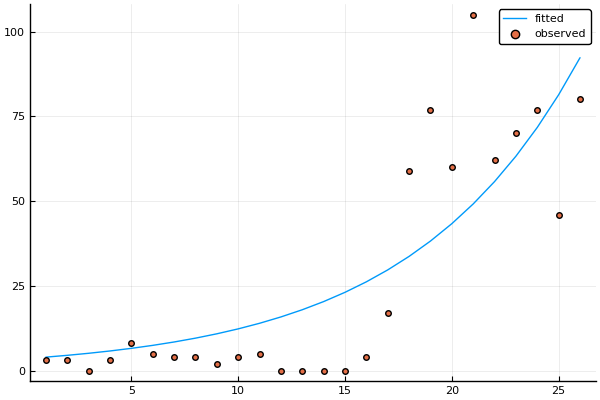

In [452]:
## run the fitted model to check the fit against the reported data. 
fittedvalues = model(1:length(incidence), myfit.param)
plot(1:length(fittedvalues), fittedvalues, label="fitted")
scatter!(1:length(incidence), incidence, label="observed")

first case happens on time index: 16


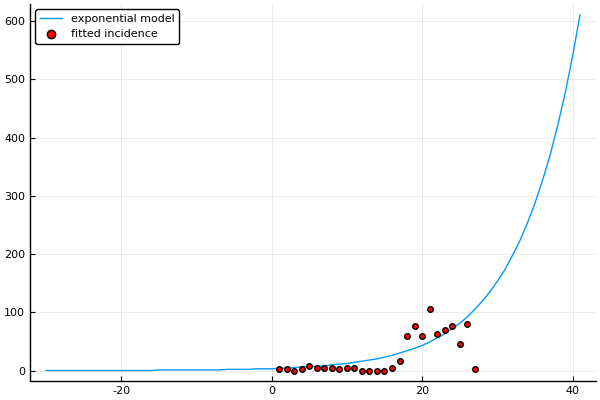

In [453]:
## run the fitted model from December 1st to Feb 10

pa = myfit.param[1] #3.121 # #3.121   # this is mean(fita)
pb = myfit.param[2] #0.1230 # #0.1230  # this is mean(fitb) 0.1230 for baseline, 0.223 for 80%, 0.1781 for 50%, 0.1539 for 20%

tidx = 1:72 # December 1st to Feb 10. 

## Use the exponential curve/model to estimate incidence
ht = collect(1:72) .- 31 # Minus 31 (since fitted data starts on January 1st)
fv = model(ht, (pa, pb))
fvr = Int.(round.(fv))  ## round the data

first_case = findfirst(x -> x == 1, fvr)
println("first case happens on time index: $(first_case)")
plot(ht, fvr, label="exponential model")


scatter!(ht[32:(32 + length(incidence))], incidence , label="fitted incidence", color="red")

In [454]:
## print final sizes from the exponential fit. 
## also look at final sizes from the negative binomial simulations later. 
println("final size Feb 10: $(cumsum(fvr)[end])")
println("final size Jan 29: $(cumsum(fvr)[end - 12])")
println("final size Jan 22: $(cumsum(fvr)[end - 19])")

final size Feb 10: 5159
final size Jan 29: 1134
final size Jan 22: 467


In [455]:
# define a function calculate the coefficient of variation of cases in window w
function cv_window(y, w)
    ny = length(y)
    w2 = Int(floor(w/2))
    
    ran = (w2+1):(ny-w)
    println("offset datarange:$ran")
    s = zeros(Float64, ny)
    m = zeros(Float64, ny)
        
    for i in ran        
        s[i] = std(y[(i - w2):(i + w2)])
        m[i] = mean(y[(i - w2):(i + w2)])
    end
    cv = s./m
    return (s, m)
end

cv_window (generic function with 1 method)

In [456]:
# calculate the coefficient of variance
win = 8
sr, mr = cv_window(fvr, win)
cvr = sr./mr
cvr[(length(tidx) - win + 1):end] .= cvr[(length(tidx) - win)]

## calculate coefficient of variation for both rounded and non rounded cases. 
cv_dd = DataFrame(ht=1:72, sr=sr, mr=mr, cvr=cvr)
pretty_table(cv_dd, crop=:none)

offset datarange:5:64
┌───────┬─────────────────────┬────────────────────┬─────────────────────┐
│    ht │                  sr │                 mr │                 cvr │
│ Int64 │             Float64 │            Float64 │             Float64 │
├───────┼─────────────────────┼────────────────────┼─────────────────────┤
│   1.0 │                 0.0 │                0.0 │                 NaN │
│   2.0 │                 0.0 │                0.0 │                 NaN │
│   3.0 │                 0.0 │                0.0 │                 NaN │
│   4.0 │                 0.0 │                0.0 │                 NaN │
│   5.0 │                 0.0 │                0.0 │                 NaN │
│   6.0 │                 0.0 │                0.0 │                 NaN │
│   7.0 │                 0.0 │                0.0 │                 NaN │
│   8.0 │                 0.0 │                0.0 │                 NaN │
│   9.0 │                 0.0 │                0.0 │                 NaN │
│  

In [457]:
## summarize the data from the exponential curve in a table to be saved (and sent to R)
## save all the information 
dec = ["D$x" for x = 1:31]
jan = ["J$x" for x = 1:31]
feb = ["F$x" for x = 1:10]
dates = [dec..., jan..., feb...]
timeidx = 1:length(dates)
datetime = (timeidx .=> dates)

## use the real data to estimate reporting. (i.e. real data against estimated data from fitted model)
#realdata = zeros(Int64, 72)
#realdata[42:(42+length(df.cumcases))] .= df.cumcases

## create a data frame to save the results 
#DataFrame(datetime, fvr=fvr)
dd = DataFrame(time=timeidx, dates=dates, cases=fvr, cumcases=cumsum(fvr), cv=cvr)
#dd[!, :pur] = (dd.cumcases .- dd.realcases)./dd.cumcases

pretty_table(dd, crop=:none)
#CSV.write("../data/estimated_incidence_$(scenstr).dat", dd)

┌───────┬────────┬───────┬──────────┬─────────────────────┐
│  time │  dates │ cases │ cumcases │                  cv │
│ Int64 │ String │ Int64 │    Int64 │             Float64 │
├───────┼────────┼───────┼──────────┼─────────────────────┤
│     1 │     D1 │     0 │        0 │                 NaN │
│     2 │     D2 │     0 │        0 │                 NaN │
│     3 │     D3 │     0 │        0 │                 NaN │
│     4 │     D4 │     0 │        0 │                 NaN │
│     5 │     D5 │     0 │        0 │                 NaN │
│     6 │     D6 │     0 │        0 │                 NaN │
│     7 │     D7 │     0 │        0 │                 NaN │
│     8 │     D8 │     0 │        0 │                 NaN │
│     9 │     D9 │     0 │        0 │                 NaN │
│    10 │    D10 │     0 │        0 │                 NaN │
│    11 │    D11 │     0 │        0 │                 NaN │
│    12 │    D12 │     0 │        0 │                 3.0 │
│    13 │    D13 │     0 │        0 │   

### Simulations via Negative Binomial 
We assume the mean incidence is the mean of an Negative-Binomial observation process. The mean of this process is fitted on the mean incidence imputed from the cumulative incidence fitted by the Richards model. The variance of the Neg-Binomial observation process is fitted on the variance of the observed daily incidence.

In [458]:
## Simulating negative binomial, we remove all the NANs and start where we have a a positive cv
## compare with the negative binomial we get from the R code. (eventually removing that part)
nanrows = findall(x -> isnan(x), dd.cv)
deleterows!(dd, nanrows);


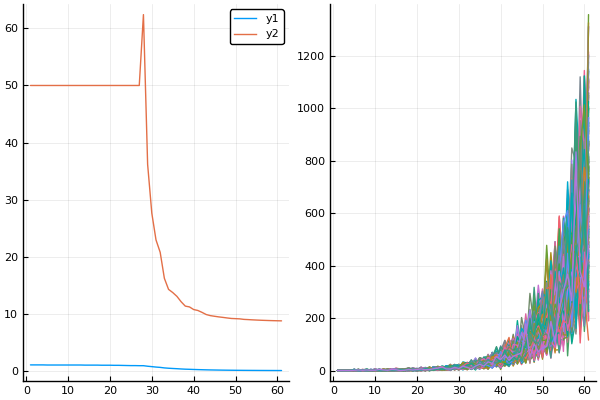

In [459]:
## do the negative binomial simulation
## mean/szv calculation from David's samoa measles code.
## convert the size/mean to probability

mean_inc = dd.cases
szv = @. 1/(dd.cv^2 - 1/mean_inc)
#for numerical stability
szv[isinf.(szv)] .= 100
szv[szv .<= 0] .= 50

prob = @.  (szv./(szv.+mean_inc))
#prob[prob .== 0] .= 0.001

nb = NegativeBinomial.(szv, prob)  

sims = rand.(nb, 500)
sims = transpose(hcat(sims...) )

l = @layout [a  b]
p1 = plot(1:length(mean_inc), [prob, szv])
p2 = plot(1:length(mean_inc), sims, legend=false)

plot(p1, p2,  layout = l)
#@. dd.cv[24:27]^2 - 1/dd.cases[24:27]


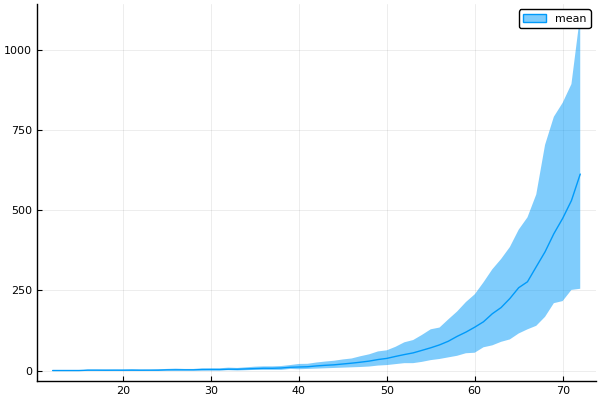

In [460]:
# summarize the data and average out the simulations. 
# need to put in a dataframe to be melted
simdf = DataFrame(sims)
insertcols!(simdf, 1, :time => dd.time)

# melt the data
simdf_melt = stack(simdf, [Symbol("x$i") for i = 1:500], [:time], variable_name=:mc, value_name=:value);

simdf_summary = simdf_melt |> @groupby(_.time) |>
    @map({time=key(_), m = mean(_.value), md = median(_.value), qlow = quantile(_.value, 0.025), qhi = quantile(_.value, 0.975)}) |> DataFrame


## the ribbon function here ADDS and SUBTRACTS the value from the main series data, so account for that.
@df simdf_summary plot(:time, [:m], label="mean", ribbon=(simdf_summary.m - simdf_summary.qlow, simdf_summary.qhi - simdf_summary.m))


The `simdf` dataframe can be used to drive R package `EpiEstim` to estimate $R_0$

In [461]:
## Plot the cumulative incidences for different days

## to do, plot the cumulative incidence with annotations. 
#jan29 = simdf_summary |> @filter(_.time <= 60 ) |> @select(_.m) |> cumsum

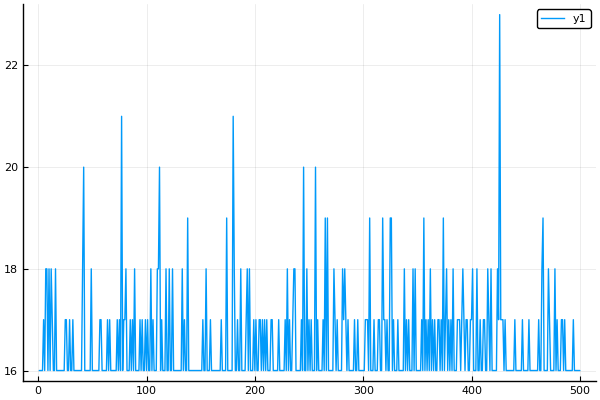

In [462]:
aa = simdf_melt |> @groupby(_.mc) |> @map({val = _.time[findfirst(x -> x > 0, _.value)]}) |> DataFrame
plot(aa.val)

In [463]:
#df.x = cumsum(ifelse.(startswith.(df.name, "A"), df.m, 0))